# Kernel O
there is bug in version 3 so in this version we will try to use the same pipeline as in vesrion 3, but use the algorithm in the old version

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [2]:
videos = glob.glob('./video_in/*.avi')
print(videos)

['./video_in/HeartRate_2.avi']


In [3]:
#just get the file name nothing less nothing more
filename_ext = os.path.basename(videos[0])
filename, file_extension  = os.path.splitext(filename_ext)
print(filename)

HeartRate_2


## kernel from the old one

In [4]:
from detect_face import haarcc_faceDetect
from detect_human_skin import skinDetector
from scipy.spatial import distance

/home/deemarc/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
faceDet_al = {'manual-r':0, 'manaul-coor':1 , 'haar':2}
# when choosing to detect face manually please congig 'face_cropRatio'
# it is a percentage ration that you want to remove from left top right down
face_cropRatio = [0.36, 0.4, 0.45, 0.10]
face_cropCoor = [240, 107, 158, 158]
x = 0
y = 0
w = 0
h = 0
def faceDetect(img_in, algor=faceDet_al['manual-r']):
    global x,y,w,h

    img_x,img_y = img_in.shape[:2]
    if algor == faceDet_al['manual-r']:
        x = face_cropRatio[0]*img_x
        y = face_cropRatio[1]*img_y
        w = img_x - face_cropRatio[2]*img_x
        h = img_y - face_cropRatio[3]*img_y
    if algor == faceDet_al['manaul-coor']:
        x = face_cropCoor[0]
        y = face_cropCoor[1]
        w = face_cropCoor[2]
        h = face_cropCoor[3]
        
    elif algor == faceDet_al['haar']:
        gray_img = cv2.cvtColor(img_in,cv2.COLOR_BGR2GRAY)
        people = haarcc_faceDetect.detect(gray_img)
        # if more than one person has been detected throw an error!
        if len(people) > 1:
            if (x+y+w+h) == 0:
                x = face_cropRatio[0]*img_x
                y = face_cropRatio[1]*img_y
                w = img_x - face_cropRatio[2]*img_x
                h = img_y - face_cropRatio[3]*img_y
            else:
                #choose the one near the last one
                preFace = [x,y,w,h]
                minDist = 100000
                minFace = []
                for person in people:
                    curFace = [person.face[0],person.face[1],person.face[2],person.face[3]]
                    dst = distance.euclidean(preFace,curFace)
                    if dst < minDist:
                        minDist = dst
                        minFace = curFace
                x = minFace[0]
                y = minFace[1]
                w = minFace[2]
                h = minFace[3]
            #raise ValueError('more than one person has been detected in an image!!!')
        elif len(people) == 1:
            person = people[0]
            x = person.face[0]
            y = person.face[1]
            w = person.face[2]
            h = person.face[3]
        elif (x+y+w+h) == 0:
            x = face_cropRatio[0]*img_x
            y = face_cropRatio[1]*img_y
            w = img_x - face_cropRatio[2]*img_x
            h = img_y - face_cropRatio[3]*img_y

    else:
        raise ValueError('faceDet_al value cannot be recognise')

    return [x,y,w,h]

In [6]:
def roi_draw(img_in, x,y,w,h):
    roi_draw_img = img_in
    cv2.rectangle(roi_draw_img,(x,y),(x+w,y+h),(0,0,255),2)
    return roi_draw_img

def roi_crop(img_in, x,y,w,h):
    roi_crop_img = img_in[y:y+h, x:x+w]
    return roi_crop_img

def colorSpaceCovert(img_in):
    #let's try lot's of color space
    # hls_img = cv2.cvtColor(img_in, cv2.COLOR_BGR2HLS)
    hsv_img = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    # lab_img = cv2.cvtColor(img_in, cv2.COLOR_BGR2Lab)

    # img_dict = {'bgr_img':img_in, 'hls_img':hls_img, 'hsv_img':hsv_img, 'lab_img':lab_img}
    # img_list.append(hls_img)
    # img_list.append(hsv_img)
    # img_list.append(lab_img)
    return hsv_img


# def cal_mm(img_in, com3=True):
#     if com3:
#         n = 3
#     else:
#         n = 1
#     mean = []   
#     median = []
#     for i in range(0,n):
#         mean.append(np.mean(img_in[:,:,i]))
#         median.append(np.median(img_in[:,:,i]))
    
#     return mean, median

def cal_mm(img_in, skinMask, com3=True, enb_skinMask = True):

    if com3:
        n = 3
    else:
        n = 1

    mean = []   
    median = []
    for i in range(0,n):
        mean.append(np.mean(img_in[:,:,i]))
        median.append(np.median(img_in[:,:,i]))
    
    if enb_skinMask:
        # using skin mask as filter
        for i in range(0, n):
            cur_arr = img_in[:,:,i]
            fil_arr = cur_arr[skinMask==1]
            mean.append(np.mean(fil_arr))
            median.append(np.median(fil_arr))

    return mean, median

In [7]:
def kernel(img_in, seq_arr_bgr,seq_arr_hsv, cvRead=True):
    
    # face detection
    x,y,w,h = faceDetect(img_in,faceDet_al['manaul-coor'])

    # for now just draw the roi
    # roi_draw_img = roi_draw(img_in,x,y,w,h)
 
    skinMask = skinDetector.detect(img_in)
    roi_crop_img = roi_crop(img_in,x,y,w,h)
    roi_crop_skinMask = roi_crop(skinMask,x,y,w,h)
    
    pro_img = cv2.bitwise_and(img_in, img_in, mask = skinMask)
    roi_draw_img = roi_draw(pro_img,x,y,w,h)
    # colorspacCoversion
    hsv_img = cv2.cvtColor(roi_crop_img, cv2.COLOR_BGR2HSV)
    img_dict = colorSpaceCovert(roi_crop_img)
    # finding mean and median
    mean, median = cal_mm(roi_crop_img,roi_crop_skinMask,enb_skinMask=False)
    seq_arr_bgr.append([mean, median])
    mean, median = cal_mm(hsv_img,roi_crop_skinMask,enb_skinMask=False)
    seq_arr_hsv.append([mean, median])    
    # put into time series array 
    return seq_arr_bgr,seq_arr_hsv,roi_draw_img  

## Try on one frame

In [27]:
# here's the main working pipeline
# we going to read out the video frame by frame
# then using our face landmark detection to marking the frame and write it out another video

# get video handle
video = videos[0]
cap_in = cv2.VideoCapture(video)
try:
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = cap_in.get(cv2.cv.CV_CAP_PROP_FPS)
        total = int(cap_in.get(cv2.cv.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
    else :
        fps = cap_in.get(cv2.CAP_PROP_FPS)
        total = int(cap_in.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
except:
    cap_in.release()
    cv2.destroyAllWindows()
    
print("the total number of frames in this video is: {0}".format(total))

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.00003000003
the total number of frames in this video is: 654


In [28]:
#testing out our kernel
seq_arr_bgr = []
seq_arr_hsv = []
countUp = 0
curPer = 0
while(True):
    ret, frame = cap_in.read()
    if not ret:
        print(ret)
        break
    seq_arr_bgr, seq_arr_hsv, ret_img = kernel(frame,seq_arr_bgr,seq_arr_hsv)
    countUp = countUp + 1
    percent = int((countUp/total)*100)
    if percent%10 == 0:
        if curPer != percent:
            print(percent)
            curPer = percent  
# cv2.imshow("images", frame)
# cv2.waitKey()
print('done')

10
20
30
40
50
60
70
80
90
False
done


In [36]:
y_arr = []
for i in range(0,6):
    y_arr.append([])

# print(len(y_arr))

for cur_arr in seq_arr_hsv:
    for row, mm_arr in enumerate(cur_arr):
        for col, comp_item in enumerate(mm_arr):
            index = row*len(mm_arr) + col
            curValue = comp_item
            y_arr[index].append(curValue)
y_arr_np_hsv = np.array(y_arr)
for cur_arr in seq_arr_bgr:
    for row, mm_arr in enumerate(cur_arr):
        for col, comp_item in enumerate(mm_arr):
            index = row*len(mm_arr) + col
            curValue = comp_item
            y_arr[index].append(curValue)
y_arr_np_bgr = np.array(y_arr)

In [48]:
y_arr_np = y_arr_np_bgr

In [49]:
print(y_arr_np)

[[ 25.36408428  25.46899535  25.47207979 ...  91.75360519  91.79462426
   91.87614164]
 [136.95565614 136.73241468 136.89272552 ... 145.54402339 145.59894248
  145.67477167]
 [166.2286092  166.26582278 166.31605512 ... 166.993751   167.06741708
  167.15494312]
 [ 21.          21.          21.         ...  71.          71.
   71.        ]
 [150.         150.5        150.         ... 133.         133.
  133.        ]
 [161.         161.         161.         ... 165.         165.
  165.        ]]


/home/deemarc/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


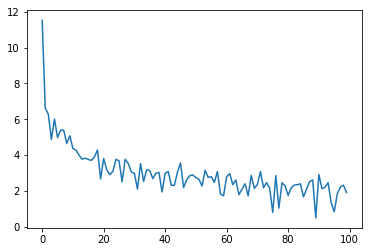

In [47]:
import scipy.fftpack


# Number of samplepoints
N = y_arr_np.shape[1]

# sample spacing
T = 1.0 / 30
xf =np.arange(N)
yf = np.log(scipy.fftpack.fft(y_arr_np[5]))
fig, ax = plt.subplots()
ax.plot(xf[0:100], yf[0:100])
plt.show()

/home/deemarc/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


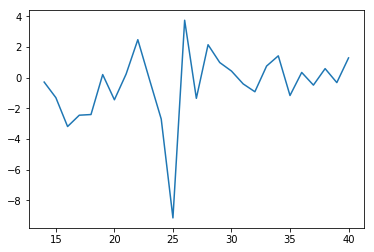

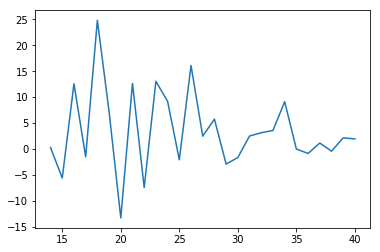

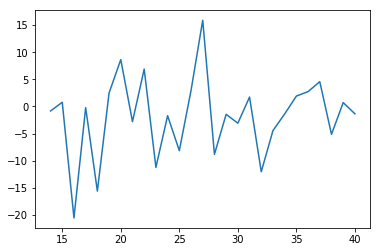

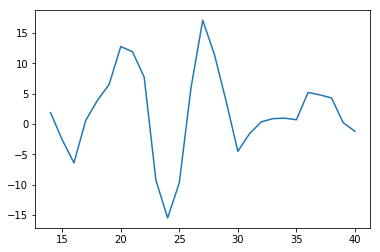

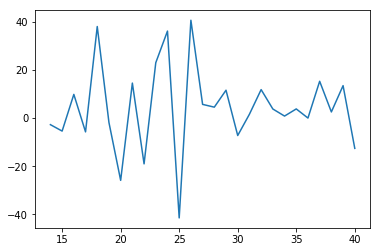

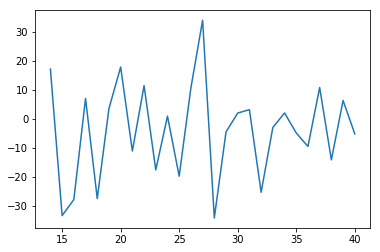

In [46]:
import scipy.fftpack


# Number of samplepoints
N = y_arr_np.shape[1]

# sample spacing
T = 1.0 / 30
xf =np.arange(N)
for idx in range(0,y_arr_np.shape[0]):
    yf = scipy.fftpack.fft(y_arr_np[idx])
    fig, ax = plt.subplots()
    ax.plot(xf[14:41], yf[14:41])
    plt.show()
# ax.plot(xf[:N//2], 2.0/N * np.abs(yf[:N//2]))


In [17]:
print(seq_arr_bgr[0][0])

[87.9608235859638, 141.97744752443518, 164.28829514500882]


In [26]:
cap_in.release()
cv2.destroyAllWindows()